In [1]:
import anndata as ad
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gseapy as gp

from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split

In [ ]:
adata_full = ad.read_h5ad(FILE := "out/results/GAT_2024-05-23-16-24-07_results.h5ad")

In [ ]:
adata = adata_full[adata_full.obs["Supertype"] == "Astrocytes"]
# adata = adata_full[adata_full.obs["Supertype"] == "Oligodendrocytes"]
# adata = adata_full[adata_full.obs["Supertype"].isin(["Excitatory_neurons_set1, Excitatory_neurons_set2", "Excitatory_neurons_set3"])]
# adata = adata_full[adata_full.obs["Supertype"] == "Inhibitory_neurons"]
# adata = adata_full[adata_full.obs["Supertype"] == "OPCs"]
# adata = adata_full[adata_full.obs["Supertype"] == "Immune_cells"]
# adata = adata_full[adata_full.obs["Supertype"] == "Vasculature_cells"]
adata

View of AnnData object with n_obs × n_vars = 136842 × 1000
    obs: 'projid', 'Supertype', 'Donor ID', 'cell_type_high_resolution', 'study', 'scaled_to', 'agreeableness', 'conscientiousness', 'extraversion_6', 'neo_altruism', 'neo_trust', 'neuroticism_12', 'openness', 'neuroticism_48', 'neuroticism_6', 'apoe_genotype', 'clin_dlb', 'cogdx', 'cogdx_stroke', 'dxpark', 'cogn_ep_lv', 'cogn_po_lv', 'cogn_ps_lv', 'cogn_se_lv', 'cogn_wo_lv', 'cognep_random_slope', 'cogng_random_slope', 'cognpo_random_slope', 'cognps_random_slope', 'cognse_random_slope', 'cognwo_random_slope', 'cogn_global_lv', 'age_bl', 'age_death', 'educ', 'msex', 'race', 'spanish', 'agefirst', 'agelast', 'menoage', 'mensage', 'natura', 'othspe00', 'whatwas', 'alcohol_g_bl', 'ldai_bl', 'q3smo_bl', 'q4smo_bl', 'smoking', 'chd_cogact_freq', 'lifetime_cogact_freq_bl', 'ma_adult_cogact_freq', 'ya_adult_cogact_freq', 'phys5itemsum_bl', 'phys5itemsum_lv', 'soc_net_bl', 'social_isolation_avg', 'social_isolation_lv', 'hypertension_bl

In [ ]:
adata = adata[adata.obs["Label"] != "Other"]  # Drop intermediate donors for this part

In [12]:
# adata = adata[adata.obs["test_donor_f4"]]  # Only use the test donors for this part

In [ ]:
FOLD = 0

In [ ]:
# Find which donors were correctly classified in fold
DONORS = adata.obs["Donor ID"].unique()

predictions = adata.uns[f"y_pred_graph_f{FOLD}"]  # Dictionary with all donors, values are np arrays of length 2 [p(CT), p(AD)]

correct_donors = []
donor_accuracies = {}  # {donor: (pred_y, pred_label, true_y, true_label)}

for donor in DONORS:
    pred_y = predictions[f"{donor}"][0, 1]  # p(AD)
    if pred_y < 0.5:
        pred_label = "CT"
    else:
        pred_label = "AD"

    true_label = adata.obs["Label"][adata.obs["Donor ID"] == donor].values[0]
    true_y = 1 if true_label == "AD" else 0

    if pred_label == true_label:
        correct_donors.append(donor)

    donor_accuracies[donor] = (pred_y, pred_label, true_y, true_label)

In [18]:
adata = adata[adata.obs["Donor ID"].isin(correct_donors)]
adata

View of AnnData object with n_obs × n_vars = 44480 × 1000
    obs: 'projid', 'Supertype', 'Donor ID', 'cell_type_high_resolution', 'study', 'scaled_to', 'agreeableness', 'conscientiousness', 'extraversion_6', 'neo_altruism', 'neo_trust', 'neuroticism_12', 'openness', 'neuroticism_48', 'neuroticism_6', 'apoe_genotype', 'clin_dlb', 'cogdx', 'cogdx_stroke', 'dxpark', 'cogn_ep_lv', 'cogn_po_lv', 'cogn_ps_lv', 'cogn_se_lv', 'cogn_wo_lv', 'cognep_random_slope', 'cogng_random_slope', 'cognpo_random_slope', 'cognps_random_slope', 'cognse_random_slope', 'cognwo_random_slope', 'cogn_global_lv', 'age_bl', 'age_death', 'educ', 'msex', 'race', 'spanish', 'agefirst', 'agelast', 'menoage', 'mensage', 'natura', 'othspe00', 'whatwas', 'alcohol_g_bl', 'ldai_bl', 'q3smo_bl', 'q4smo_bl', 'smoking', 'chd_cogact_freq', 'lifetime_cogact_freq_bl', 'ma_adult_cogact_freq', 'ya_adult_cogact_freq', 'phys5itemsum_bl', 'phys5itemsum_lv', 'soc_net_bl', 'social_isolation_avg', 'social_isolation_lv', 'hypertension_bl'

<Axes: xlabel='PCA1', ylabel='Count'>

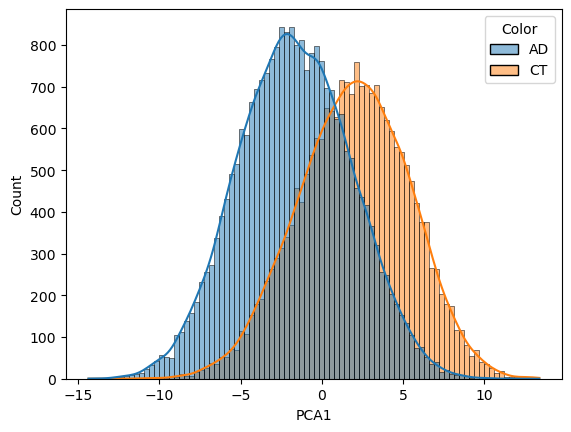

In [ ]:
pca = PCA(n_components=5)
x_pca = pca.fit_transform(adata.obsm[f"h_2_f{FOLD}"].toarray())

df = pd.DataFrame({
    "PCA1": x_pca[:, 0],
    # "PCA2": x_pca[:, 1],
    "Color": adata.obs["Label"].values
})
sns.histplot(df, x="PCA1", hue="Color", kde=True)

In [ ]:
from sklearn.model_selection import train_test_split

# Train a linear regrsesion to predict the first PCA from gene expression
# X_train, X_test, y_train, y_test = train_test_split(adata.X, x_pca[:, 0], test_size=0.33, random_state=41)

# Oops, but we have to split by donor, not by cell
# We can do this by splitting the donors
donors = adata.obs["Donor ID"].unique()
donors_train, donors_test = train_test_split(donors, test_size=0.33, random_state=41)
X_train = adata.X[adata.obs["Donor ID"].isin(donors_train)]
X_test = adata.X[adata.obs["Donor ID"].isin(donors_test)]
y_train = x_pca[adata.obs["Donor ID"].isin(donors_train), 0]
y_test = x_pca[adata.obs["Donor ID"].isin(donors_test), 0]

reg = LinearRegression().fit(X_train, y_train)
lasso = Lasso(alpha=0.0001).fit(X_train, y_train)

print("reg score:", reg.score(X_test, y_test))
print("lasso score:", lasso.score(X_test, y_test))
# Output: 0.9977079544674875

reg score: 0.9976277942272
lasso score: 0.997593273078963


I checked, and the training split has very little influence on the score of the model and on the coefficients, so I will just use the entire dataset here.

In [ ]:
reg = LinearRegression().fit(adata.X, x_pca[:, 0])
lasso = Lasso(alpha=0.05).fit(adata.X, x_pca[:, 0])

print("reg score:", reg.score(adata.X, x_pca[:, 0]))
print("lasso score:", lasso.score(adata.X, x_pca[:, 0]))

reg score: 0.9978782869742009
lasso score: 0.9104154151596144


Text(0, 0.5, 'Lasso coefficients')

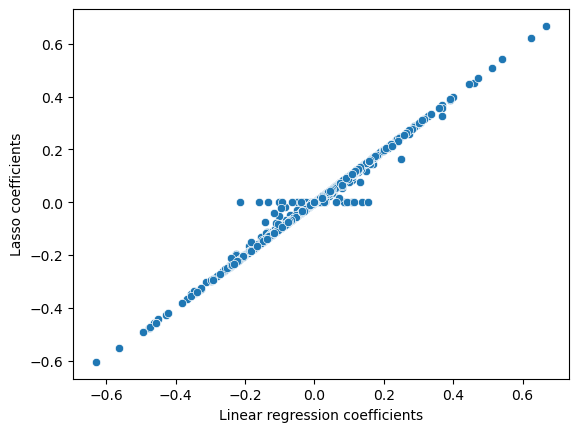

In [ ]:
sns.scatterplot(
    x=reg.coef_,
    y=lasso.coef_
)
plt.xlabel("Linear regression coefficients")
plt.ylabel("Lasso coefficients")

In [23]:
ranking = pd.Series(reg.coef_, index=adata.var_names)
ranking = ranking[ranking.abs().sort_values(ascending=False).index]
ranking.head(20)

AC069277.1    0.668741
NPAS4        -0.630749
LINC01515     0.623133
AC100801.1   -0.563869
C5orf17       0.541588
MIR646HG      0.510335
AGMO         -0.493323
WDR64        -0.475797
ARC          -0.474145
LINC02112     0.470967
HSPA6        -0.462698
CCDC13-AS1    0.458649
CHRM5        -0.457105
MIR2052HG    -0.456908
SERPINE1     -0.450987
AC098829.1    0.446520
PLD5         -0.428032
AC018680.1   -0.422024
HBB           0.398525
CRH           0.391788
dtype: float64

233it [00:07, 35.36it/s]C:\Users\timo\AppData\Local\Temp\ipykernel_92636\3540589261.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = spearmanr(adata.X[:, i].toarray().flatten(), x_pca[:, 0])
1000it [00:29, 33.62it/s]


<Axes: ylabel='Count'>

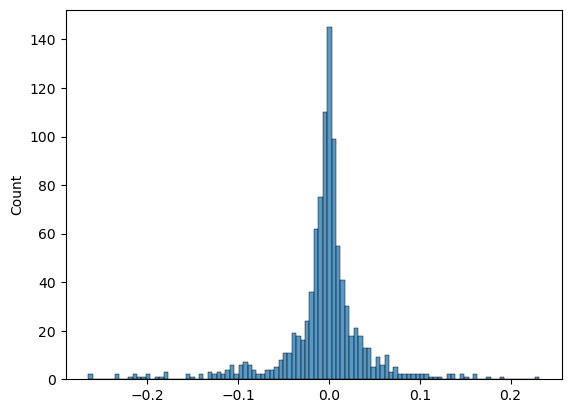

In [29]:
# Try spearman correlation between each gene's expression and the 1st PC instead

from tqdm import tqdm
from scipy.stats import spearmanr

spearman_corrs = []

for i, gene in tqdm(enumerate(adata.var_names)):
    corr, _ = spearmanr(adata.X[:, i].toarray().flatten(), x_pca[:, 0])
    spearman_corrs.append(corr)

spearman_corrs = pd.Series(spearman_corrs, index=adata.var_names)

sns.histplot(spearman_corrs)

Text(0, 0.5, 'Spearman correlation')

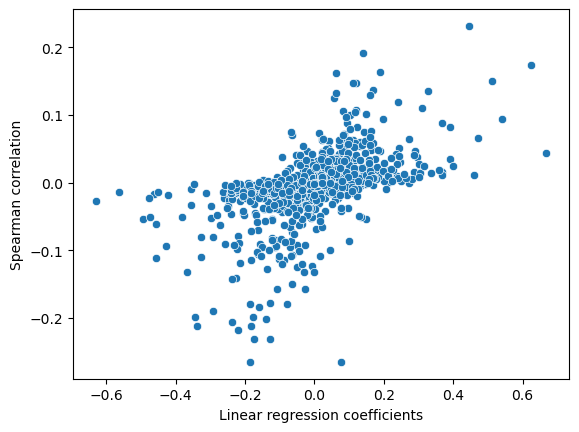

In [30]:
sns.scatterplot(
    x=reg.coef_,
    y=spearman_corrs,
)
plt.xlabel("Linear regression coefficients")
plt.ylabel("Spearman correlation")

<Axes: ylabel='Count'>

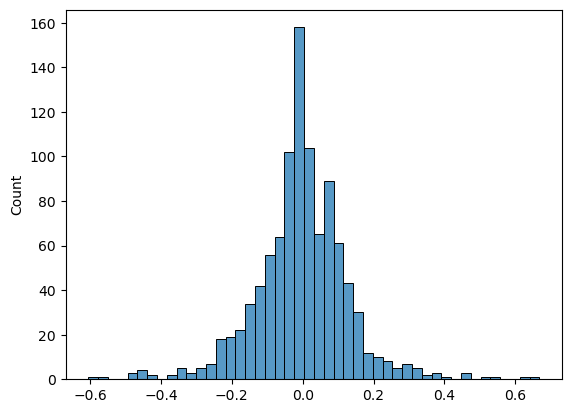

In [25]:
sns.histplot(lasso.coef_)
# plt.yscale("log")

In [31]:
ranking = pd.Series(spearman_corrs, index=adata.var_names)
ranking = ranking[ranking.abs().sort_values(ascending=False).index]
ranking.head(20)

NEAT1        -0.264822
MT2A         -0.264612
AC098829.1    0.231762
MT1E         -0.231681
MT1G         -0.231382
MT1M         -0.217227
GFAP         -0.212264
SLC25A18     -0.211731
ITPKB        -0.206461
MT1X         -0.201880
RANBP3L      -0.198775
CHI3L1       -0.198542
AC002429.2    0.191755
AC104574.2   -0.189570
FAM107A      -0.182974
ANGPTL4      -0.179901
HILPDA       -0.178674
SLC7A2       -0.177999
LINC01515     0.174654
PAMR1         0.163386
dtype: float64

<Axes: >

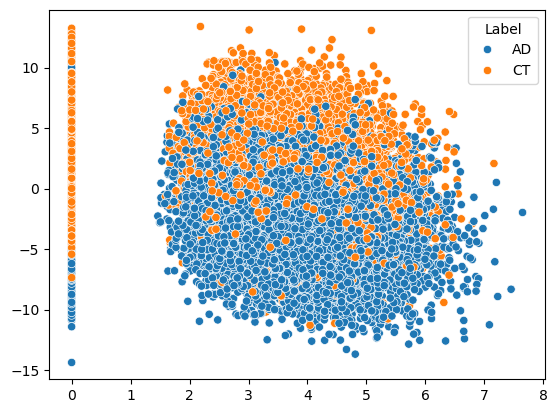

In [34]:
sns.scatterplot(
    x = adata[:, adata.var_names == "MT2A"].X.toarray().flatten(),
    y = x_pca[:, 0],
    hue = adata.obs["Label"]
)

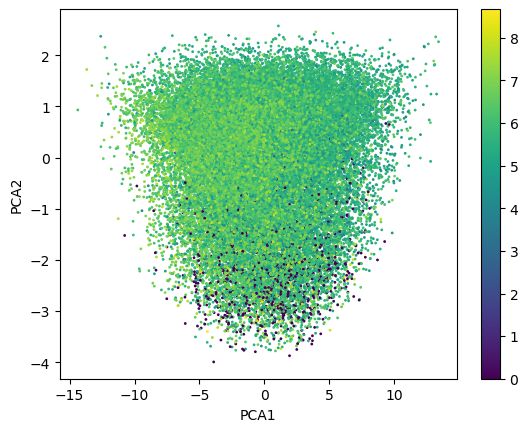

In [36]:
# Color PCA according to top gene

df = pd.DataFrame({
    "PCA1": x_pca[:, 0],
    "PCA2": x_pca[:, 1],
    "Color": adata[:, adata.var_names == "NEAT1"].X.toarray().flatten(),
})

plt.scatter(
    df["PCA1"],
    df["PCA2"],
    c=df["Color"],
    cmap="viridis",
    s=1,
)
plt.colorbar()
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.show()

# Gene Set Enrichment Analysis

In [54]:
ranking = pd.Series(reg.coef_, index=adata.var_names)
ranking = ranking[ranking.abs().sort_values(ascending=False).index]
ranking

LINC01515     0.615600
C5orf17       0.536242
AC069277.1    0.514048
MIR646HG      0.507613
MIR2052HG    -0.452135
                ...   
LINC01798     0.000000
LINC01828     0.000000
EGR4         -0.000000
S100Z         0.000000
DPYD-AS1     -0.000000
Length: 1000, dtype: float64

In [61]:
res.results.keys()

dict_keys(['Allen_Brain_Atlas_down__internal globus pallidus', 'Allen_Brain_Atlas_down__Bed nuclei of the stria terminalis, anterior division, magnocellular nucleus', 'Allen_Brain_Atlas_up__Anterior pretectal nucleus', 'Allen_Brain_Atlas_10x_scRNA_2021__Mouse 5 Lamp5 Lhx6 up', 'Allen_Brain_Atlas_up__dorsal part of m1A', 'Allen_Brain_Atlas_up__parabrachial part of the periaqueductal gray', 'Allen_Brain_Atlas_down__mantle zone of r2Co', 'Allen_Brain_Atlas_up__Nucleus of reunions', 'Allen_Brain_Atlas_up__Parastrial nucleus', 'Allen_Brain_Atlas_down__periventricular stratum of r5Tr', 'Allen_Brain_Atlas_down__mantle zone of PcPD', 'Allen_Brain_Atlas_down__Paraventricular hypothalamic nucleus', 'Allen_Brain_Atlas_10x_scRNA_2021__Mouse 306 L5 NP CTX up', 'Allen_Brain_Atlas_down__Pontine gray', 'Allen_Brain_Atlas_down__ventral paracommissural tectal nucleus, m1 part', 'Allen_Brain_Atlas_down__dorsal tier of thalamus', 'Allen_Brain_Atlas_up__mantle zone of r1Ve', 'Allen_Brain_Atlas_up__lateral 

In [72]:
res = gp.prerank(
    rnk=ranking, 
    gene_sets=[
        # "Aging_Perturbations_from_GEO_down",
        # "Aging_Perturbations_from_GEO_up",
        "Allen_Brain_Atlas_10x_scRNA_2021",
        "Allen_Brain_Atlas_down",
        "Allen_Brain_Atlas_up",
        # "DisGeNET",
        # "GO_Biological_Process_2023",
        # "GO_Cellular_Component_2023",
        # "GO_Molecular_Function_2023"
        # "GTEx_Aging_Signatures_2021",
        # "GWAS_Catalog_2023",
        # "HDSigDB_Human_2021",
    ],
    # outdir="out/results/gsea/Ast_GO-2023", 
    min_size=1, 
    max_size=5000, 
    # permutation_num=1000,
    verbose=True,
    ascending=False,
)

2024-11-07 14:21:22,857 [WARNING] Input gene rankings contains NA values(gene name and ranking value), drop them all!
2024-11-07 14:21:22,859 [INFO] Parsing data files for GSEA.............................
2024-11-07 14:21:22,860 [INFO] Enrichr library gene sets already downloaded in: C:\Users\timo\.cache/gseapy, use local file
2024-11-07 14:21:22,881 [INFO] Enrichr library gene sets already downloaded in: C:\Users\timo\.cache/gseapy, use local file
2024-11-07 14:21:23,014 [INFO] Enrichr library gene sets already downloaded in: C:\Users\timo\.cache/gseapy, use local file
2024-11-07 14:21:23,321 [INFO] 0089 gene_sets have been filtered out when max_size=5000 and min_size=1
2024-11-07 14:21:23,322 [INFO] 5061 gene_sets used for further statistical testing.....
2024-11-07 14:21:23,322 [INFO] Start to run GSEA...Might take a while..................
2024-11-07 14:21:30,659 [INFO] Congratulations. GSEApy runs successfully................



In [65]:
# Show only significant results
res.res2d[res.res2d["FDR q-val"] < 0.05]

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes


In [63]:
res_df = res.res2d.copy()
# res_df.insert(0, "Adjusted P-value", res_df["NOM p-val"])
res_df["Adjusted P-value"] = res.res2d["NOM p-val"]  # Compatibility fix
gp.plot.dotplot(res_df, title=res.results.keys()[0], top_term=20, figsize=(10, 15))

AttributeError: 'dict_keys' object has no attribute 'tolist'